# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  


In [20]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer

%matplotlib inline

In [29]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### `portfolio` dataset preparation

In [30]:
portfolio.shape

(10, 6)

In [31]:
portfolio.dtypes

channels      object
difficulty     int64
duration       int64
id            object
offer_type    object
reward         int64
dtype: object

In [32]:
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


We can see some variables that could use some preprocessing, such as `channels` which is a list of values. We'll use [Scikit-learn's MultiLabelBinarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html) to transform it.

Then we'll create a copy of the original `portfolio` dataset with the new encoded columns.

In [33]:
mlb = MultiLabelBinarizer()
encoded_channels = mlb.fit_transform(portfolio['channels'])

In [34]:
encoded_channels_df = pd.DataFrame(encoded_channels,
                                   columns = mlb.classes_,
                                   index = portfolio['channels'].index)
encoded_channels_df.head()

,email,mobile,social,web
0,1,1,1,0
1,1,1,1,1
2,1,1,0,1
3,1,1,0,1
4,1,0,0,1


In [35]:
processed_portfolio = portfolio.copy()

processed_portfolio = processed_portfolio.join(encoded_channels_df)
processed_portfolio.head()

,channels,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


In [36]:
processed_portfolio = processed_portfolio.drop('channels', axis = 1)
print(processed_portfolio)

   difficulty  duration                                id     offer_type  \
0          10         7  ae264e3637204a6fb9bb56bc8210ddfd           bogo   
1          10         5  4d5c57ea9a6940dd891ad53e9dbe8da0           bogo   
2           0         4  3f207df678b143eea3cee63160fa8bed  informational   
3           5         7  9b98b8c7a33c4b65b9aebfe6a799e6d9           bogo   
4          20        10  0b1e1539f2cc45b7b9fa7c272da2e1d7       discount   
5           7         7  2298d6c36e964ae4a3e7e9706d1fb8c2       discount   
6          10        10  fafdcd668e3743c1bb461111dcafc2a4       discount   
7           0         3  5a8bc65990b245e5a138643cd4eb9837  informational   
8           5         5  f19421c1d4aa40978ebb69ca19b0e20d           bogo   
9          10         7  2906b810c7d4411798c6938adc9daaa5       discount   

   reward  email  mobile  social  web  
0      10      1       1       1    0  
1      10      1       1       1    1  
2       0      1       1       0    1  
3  

In [37]:
processed_portfolio.isna().sum()

difficulty    0
duration      0
id            0
offer_type    0
reward        0
email         0
mobile        0
social        0
web           0
dtype: int64

No empty cells, looks like this dataset is good enough for now.

### `profile` dataset preparation

In [38]:
profile.shape

(17000, 5)

In [39]:
profile.dtypes

age                   int64
became_member_on      int64
gender               object
id                   object
income              float64
dtype: object

In [40]:
profile.head(10)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


The `profile` dataset has some interesting characteristics, such as:
* `NaN` values for the `income` column.
* `None` value for the `gender`column (which is ok, since there are more genders than M and F, but this might need to be treated).
* `became_member_on` has dates that are treated as numbers.
* `age` has the value `118` repeated several times. Since it's fairly unlikely for the customers to be 118 years-old, I'm assuming this is also some kind of previous data preprocessing and won't change it.

In [41]:
profile.isna().head(10)

,age,became_member_on,gender,id,income
0,False,False,True,False,True
1,False,False,False,False,False
2,False,False,True,False,True
3,False,False,False,False,False
4,False,False,True,False,True
5,False,False,False,False,False
6,False,False,True,False,True
7,False,False,True,False,True
8,False,False,False,False,False
9,False,False,True,False,True


In [42]:
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

The `None` value for `gender` is not understood as a value, so it needs treatment. We'll fill the `None` values with `Unknown`.

In [43]:
processed_profile = profile.copy()

processed_profile['gender'].fillna('Unknown', inplace = True)
processed_profile.head(10)

,age,became_member_on,gender,id,income
0,118,20170212,Unknown,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,Unknown,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,Unknown,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,Unknown,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,Unknown,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,Unknown,8974fc5686fe429db53ddde067b88302,NaN


For the `income` column, let's see what's the data distribution without the `NaN`s:

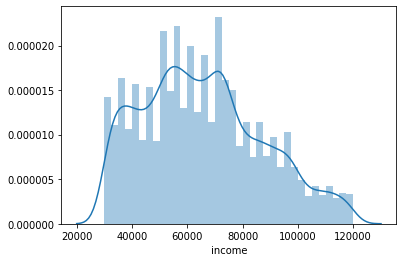

In [44]:
sns.distplot(profile['income'].dropna());

In [45]:
profile['income'].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

By filling the `NaN`s with some value, we'll change the distribution's shape. Since both mean and median are fairly close to each other, it doesn't matter much which one we'll use.
I chose the mean.

In [46]:
processed_profile['income'].fillna(profile['income'].mean(), inplace = True)
processed_profile.head(10)

,age,became_member_on,gender,id,income
0,118,20170212,Unknown,68be06ca386d4c31939f3a4f0e3dd783,65404.991568
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.000000
2,118,20180712,Unknown,38fe809add3b4fcf9315a9694bb96ff5,65404.991568
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.000000
4,118,20170804,Unknown,a03223e636434f42ac4c3df47e8bac43,65404.991568
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.000000
6,118,20170925,Unknown,8ec6ce2a7e7949b1bf142def7d0e0586,65404.991568
7,118,20171002,Unknown,68617ca6246f4fbc85e91a2a49552598,65404.991568
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.000000
9,118,20161122,Unknown,8974fc5686fe429db53ddde067b88302,65404.991568


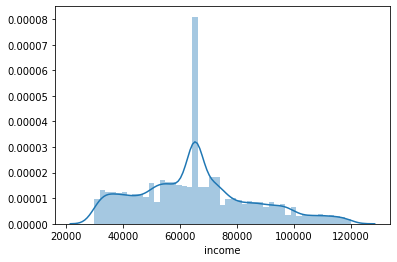

In [47]:
sns.distplot(processed_profile['income']);

We can see it changed a bit the distribution of the data, but we were already expecting that.

In [48]:
processed_profile.isna().sum()

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64

No empty cells, looks like this dataset is good enough for now.

### `transcript` dataset preparation

In [49]:
transcript.shape

(306534, 4)

In [50]:
transcript.dtypes

event     object
person    object
time       int64
value     object
dtype: object

In [51]:
transcript.head(10)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [52]:
transcript.isna().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [54]:
transcript.sample(10)

,event,person,time,value
85989,transaction,0ef5270c4e634eccbfcf23a172921a8d,216,{'amount': 271.74}
111220,offer received,3d63a807a77c4a5686a7515f65bb86a6,336,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
288184,transaction,a9846b5ea8034e9aac84cb64079e10f8,642,{'amount': 25.2}
248125,offer received,9d8b11f8ae6c45c5bffc7d7bd1782db7,576,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
152624,offer received,89f451a5a8c64683b57aca2a334117ef,408,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
158908,offer received,f22e272f28284d3cbd5eee68341225b4,408,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
62558,offer received,828dac4565f347c08ec68791043a536c,168,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
159381,offer received,9f28a2d7e8874cc39ef8ca04d4d53ff8,408,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
106570,transaction,c52343cf47e84dadbedd0b9632d626ec,306,{'amount': 2.98}
43322,transaction,b23a9899a5674d2a8ebb29f79ab15544,108,{'amount': 0.41000000000000003}


This dataset has no empty values. The `value` column has a dictionary that has different keys and values.